In [1]:
import time
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import lidcdataset as lidc

construct_start = time.time()

#constructing the dataset
img_dir = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/images/"
mask_dir = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/labels/"
dataset = lidc.LIDCDataset(img_dir, mask_dir)

#splitting the dataset
train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15])

#data loaders
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#test
images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

construct_end = time.time()
print(f"Construct runtime {construct_end - construct_start}")



Image batch shape: torch.Size([32, 1, 64, 64])
Mask batch shape: torch.Size([32, 1, 64, 64])
Construct runtime 0.023014307022094727


In [2]:
import models
import loops
import utils
import torch
import torch.nn as nn
import torch.optim as optim

#setting up training
model = models.Unet2D()
device = torch.device("cpu")
criterion = utils.ComboLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 300
early_stopping = utils.EarlyStopping(patience=15, delta=0.001)

#constructing trainer
trainer = loops.Trainer(
    model=model, 
    device=device, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=num_epochs, 
    early_stopping=early_stopping, 
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader, 
    save_path="Images/loss_test.png"
    )

Epoch [1/300]  Train Loss: 0.6733  Val Loss: 0.7341   Runtime: 1.6814329624176025
Epoch [2/300]  Train Loss: 0.6058  Val Loss: 0.7232   Runtime: 1.6908459663391113
Epoch [3/300]  Train Loss: 0.5775  Val Loss: 0.6992   Runtime: 1.198390245437622
Epoch [4/300]  Train Loss: 0.5519  Val Loss: 0.6687   Runtime: 1.2311530113220215
Epoch [5/300]  Train Loss: 0.5276  Val Loss: 0.6320   Runtime: 1.2093610763549805
Epoch [6/300]  Train Loss: 0.5151  Val Loss: 0.6036   Runtime: 1.1734850406646729
Epoch [7/300]  Train Loss: 0.5040  Val Loss: 0.5665   Runtime: 1.1489129066467285
Epoch [8/300]  Train Loss: 0.4902  Val Loss: 0.5288   Runtime: 1.1425600051879883
Epoch [9/300]  Train Loss: 0.4805  Val Loss: 0.4969   Runtime: 1.1807382106781006
Epoch [10/300]  Train Loss: 0.4709  Val Loss: 0.4779   Runtime: 1.1713409423828125
Epoch [11/300]  Train Loss: 0.4673  Val Loss: 0.4720   Runtime: 1.1404149532318115
Epoch [12/300]  Train Loss: 0.4602  Val Loss: 0.4563   Runtime: 1.13861083984375
Epoch [13/300]  

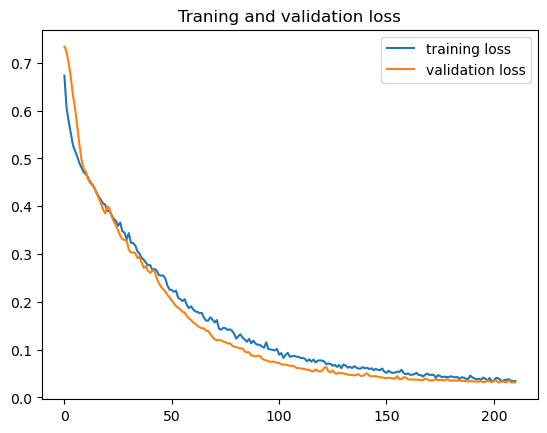

In [3]:
trainer.train()

In [7]:
trainer.test()

Test runtime 0.0812222957611084
Mean dice coefficient on test set: 0.9578
Mean loss on test set: 0.0403


Saved visualization to Images/single_prediction.png


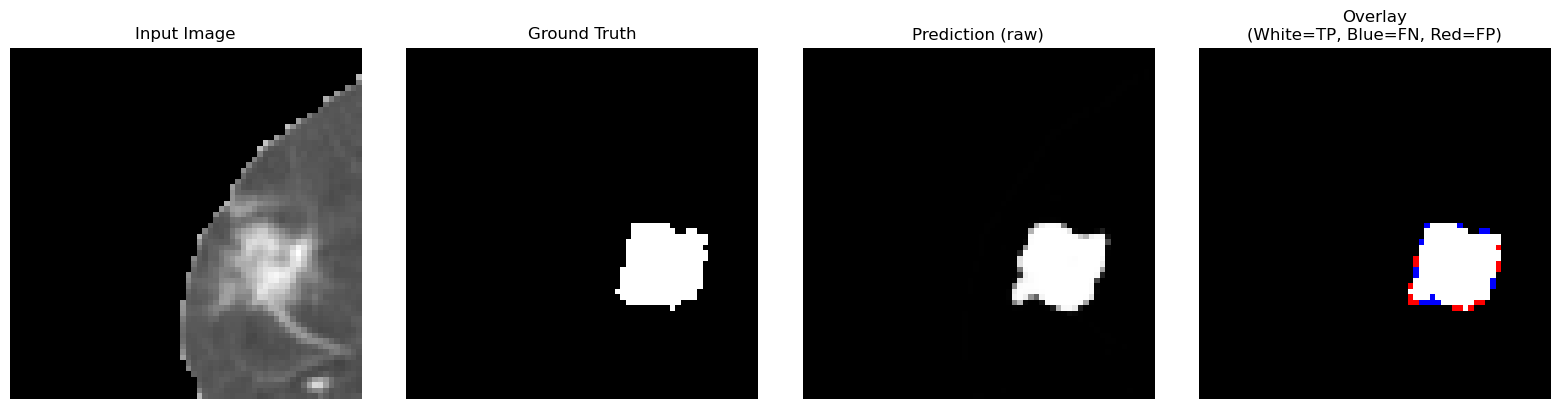

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model = trainer.get_model()

def visualize_prediction(image, mask, prediction, threshold=0.5, save_path=None):
    """
    Visualize segmentation prediction with color-coded overlay.
    
    Args:
        image: Input image tensor (1, H, W) or (H, W)
        mask: Ground truth mask tensor (1, H, W) or (H, W)
        prediction: Model prediction tensor (1, H, W) or (H, W), values 0-1
        threshold: Threshold for binarizing predictions (default 0.5)
        save_path: Path to save the figure (optional)
    
    Color coding:
        - White: Intersection (True Positives)
        - Blue: Mask only (False Negatives)
        - Red: Prediction only (False Positives)
        - Black: Background (True Negatives)
    """
    # Convert to numpy and remove channel dimension if present
    if isinstance(image, torch.Tensor):
        image = image.cpu().squeeze().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().squeeze().numpy()
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().squeeze().numpy()
    
    # Binarize prediction
    pred_binary = (prediction > threshold).astype(np.float32)
    mask_binary = mask.astype(np.float32)
    
    # Calculate intersection and differences
    intersection = (pred_binary * mask_binary)  # Both 1 (True Positive)
    mask_only = mask_binary - intersection      # Mask=1, Pred=0 (False Negative)
    pred_only = pred_binary - intersection      # Pred=1, Mask=0 (False Positive)
    
    # Create RGB overlay
    overlay = np.zeros((*image.shape, 3))
    
    # White for intersection (TP)
    overlay[intersection == 1] = [1, 1, 1]
    
    # Blue for mask only (FN)
    overlay[mask_only == 1] = [0, 0, 1]
    
    # Red for prediction only (FP)
    overlay[pred_only == 1] = [1, 0, 0]
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Ground truth mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    # Prediction
    axes[2].imshow(prediction, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title(f'Prediction (raw)')
    axes[2].axis('off')
    
    # Color-coded overlay
    axes[3].imshow(overlay)
    axes[3].set_title('Overlay\n(White=TP, Blue=FN, Red=FP)')
    axes[3].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()


def save_multiple_predictions(model, test_loader, device, num_samples=5, 
                              threshold=0.5, save_dir='predictions'):
    """
    Save multiple prediction visualizations.
    
    Args:
        model: Trained model
        test_loader: Test data loader
        device: Device (cuda/cpu)
        num_samples: Number of samples to visualize
        threshold: Threshold for binarizing predictions
        save_dir: Directory to save images
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    count = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            # Visualize samples from this batch
            batch_size = images.size(0)
            for i in range(min(batch_size, num_samples - count)):
                save_path = os.path.join(save_dir, f'prediction_{count+1}.png')
                visualize_prediction(
                    images[i],
                    masks[i],
                    outputs[i],
                    threshold=threshold,
                    save_path=save_path
                )
                count += 1
                
                if count >= num_samples:
                    return
    
    print(f"Saved {count} visualizations to {save_dir}/")


'''# Example usage:
# After testing loop
if __name__ == "__main__":
    # Save 5 example predictions
    save_multiple_predictions(
        model=model,
        test_loader=test_loader,
        device=device,
        num_samples=5,
        threshold=0.5,
        save_dir='test_predictions'
    )'''
    
# Or visualize just one example
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    
    # Visualize first image in batch
    visualize_prediction(
        images[0],
        masks[0],
        outputs[0],
        threshold=0.5,
        save_path='Images/single_prediction.png'
    )
